In [1]:
import numpy as np
import matplotlib.pyplot as plt
from read_lapd import read_lapd_data
# from toolbox import bdot
from bdot_calib import bint_fft
import numpy as np
from scipy import constants as const
from scipy import fft
import time
from scipy.ndimage import maximum_filter1d, uniform_filter1d

Reading data from motion list XY[2]: Ta_paddle
Reading motion list from module:  6K Compumotor
No 3302 boards used.
SIS 3305 boards used = [1, 2]
SIS 3305 effective clock rate: Board 1 = 5000.0 MHz
SIS 3305 effective clock rate: Board 2 = 5000.0 MHz
---------- SIS 3305 list of enabled channels (4) ----------
[ 0] Board 1, Channel 1: Bx-P25mov
[ 1] Board 1, Channel 5: By-P25mov
[ 2] Board 2, Channel 1: Bz-P25mov
[ 3] Board 2, Channel 5: By-P26fxd
------------------------------------------------------------
Reading SIS 3305...
------------------------------------------------------------
Data geometry = x-line
Read Channels = 1
Shot range    = 0 to 0
X value range = 0 to 0
Y value range = 0 to 0
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/1) of (1/1/1/1/1/1)
1 5
Reading config name /Raw data + config/SIS crate/siscf0-4ch-5GHz-1Mpnts-200us [Slot 13: SIS 3305 FPGA 2 ch 1]
!!! (nt, nx, ny, nshots, nchan) = (1007616, 1, 1, 1, 1)
{'Calibration tag': b'07/20/2020', 'Profile z locations': array([-

/tmp/ipykernel_702880/1973935184.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


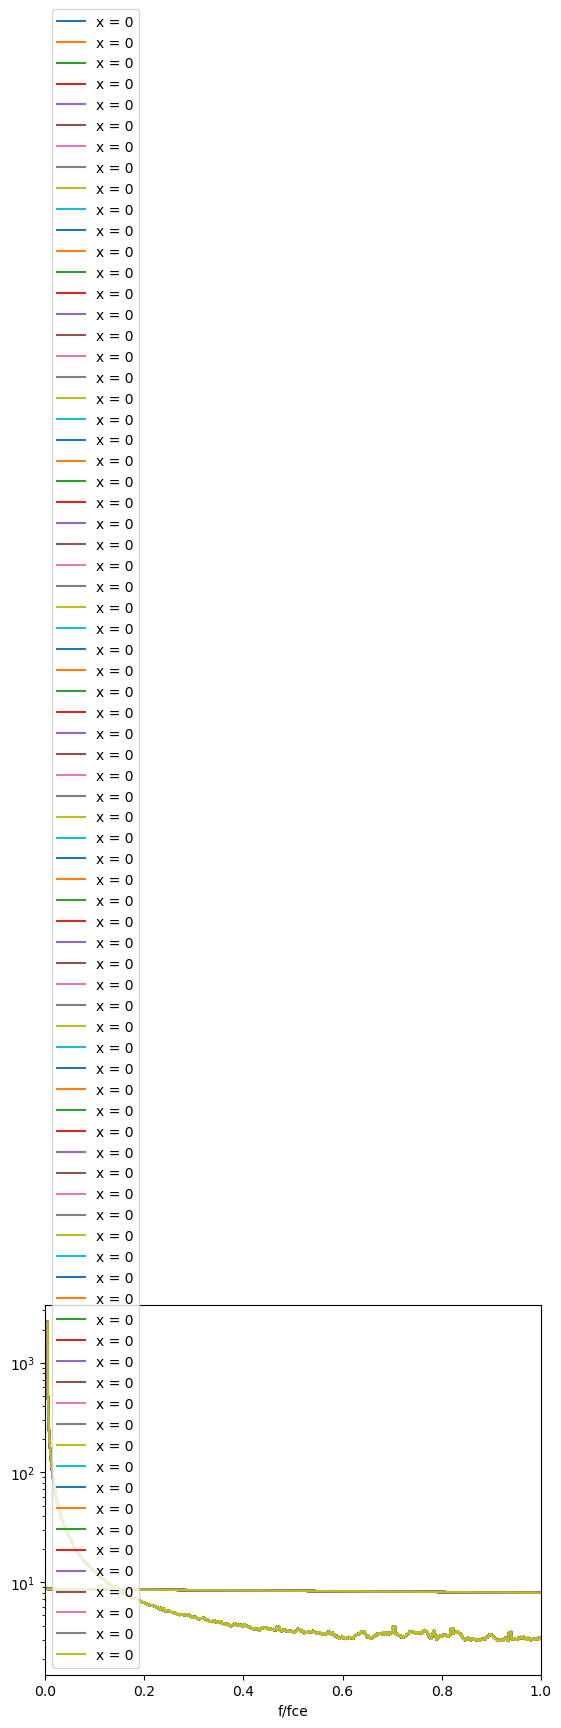

In [2]:
datapath = '/data/BAPSF_Data/Energetic_Electron_Ring/jul2021/'
filename = datapath + \
        '11-bfield-bmirror-scan-p25-xline-uwave-l5ms-mirror-min-305G.hdf5'

#fig, axs = plt.subplots(2, 1, figsize=[9.6,4.8])

# filename = datapath + \
#         '24-bfield-p25-xline-uwave-off-mirror-min-305G.hdf5'
#24-bfield-p25-xline-uwave-off-mirror-min-305G.hdf5
savepath = './'
# read data of one channel in one shot and one location
for xx in range (1):
    data = read_lapd_data(filename, rchan=[1], rshot=[0], xrange=[2*xx]) 
    
    
    # fft
    n0 = data['data'].shape[0]
    nfast = 2**(int(np.log2(n0-1))+1)
    freq = fft.fftfreq(nfast, d=data['dt'][0])
    emf_fft = fft.fft(data['data'], n=nfast, axis=0)
    emf_fft = np.squeeze(emf_fft)

    emf_max = maximum_filter1d(np.abs(emf_fft), size=1000, mode='wrap')
    emf_mean = uniform_filter1d(np.abs(emf_fft), size=1000, mode='wrap')
    emf_ratio_median = np.median(emf_max / emf_mean)
    emf_ratio_mean = np.mean(emf_max / emf_mean)
    print('median(emf_max / emf_mean) = {}'.format(emf_ratio_median))
    print('mean(emf_max / emf_mean) = {}'.format(emf_ratio_mean))



    def calcRegionBounds(bool_array):
        '''
        Returns the lower and upper bounds of contiguous regions.

        Parameters
        ==========
        bool_array    1-D Binary numpy array
        '''
        assert(bool_array.dtype=='bool')
        idx = np.diff(np.r_[0, bool_array, 0]).nonzero()[0]
        assert(len(idx)%2 == 0)
        return np.reshape(idx, (-1,2))

    # index of short pulses
    idx = (emf_max / emf_mean) > 4
    # calculate bounds of short pulses
    ibd = calcRegionBounds(idx)


    emf_copy = emf_fft.copy()
    for i in range(ibd.shape[0]):
        aux_arr = np.arange(ibd[i,0], ibd[i,1])
        # The first and last chunks are contiguous
        if i == 0 and ibd[0,0] == 0 and ibd[-1,1] == len(emf_fft):
            lwgt = (ibd[0,1] - aux_arr) \
                    / (ibd[0,1] + ibd[-1,1] - ibd[-1,0] + 1)
            rwgt = (aux_arr + ibd[-1,1] - ibd[-1,0] + 1) \
                    / (ibd[0,1] + ibd[-1,1] - ibd[-1,0] + 1)
            lval = emf_fft[ibd[-1,0]-1]
            rval = emf_fft[ibd[0,1]]
        elif i == ibd.shape[0]-1 and ibd[-1,1] == len(emf_fft) and ibd[0,0] == 0:
            lwgt = (ibd[-1,1] - aux_arr + ibd[0,1]) \
                    / (ibd[-1,1] - ibd[-1,0] + ibd[0,1] +1)
            rwgt = (aux_arr - ibd[-1,0] + 1) \
                    / (ibd[-1,1] - ibd[-1,0] + ibd[0,1] +1)
            lval = emf_fft[ibd[-1,0]-1]
            rval = emf_fft[ibd[0,1]]
        # Contiguous sections in between
        else:
            lwgt = (ibd[i,1] - aux_arr) / (ibd[i,1] - ibd[i,0] + 1)
            rwgt = (aux_arr - ibd[i,0] + 1) / (ibd[i,1] - ibd[i,0] + 1)
            lval = emf_fft[ibd[i,0]-1]
            rval = emf_fft[ibd[i,1]%len(emf_fft)]
        emf_copy[ibd[i,0]:ibd[i,1]] = lwgt*lval + rwgt*rval

        window_size = 1000  # Adjust based on your smoothing requirements

        # Define a simple moving average function
        def moving_average(data, size):
            return np.convolve(data, np.ones(size), 'valid') / size

        # Apply the moving average filter
        smoothed_emf_fft = moving_average(np.abs(emf_fft), window_size)

        # Since the moving average reduces the array size, adjust the frequency array
        # We take the center point of each window for the frequency
        adjusted_freq = freq[window_size-1:]  # Adjusting freq array size to match smoothed signal

        # For plotting, you might still want to decimate or just plot the smoothed data
        # Here, we just plot the smoothed data
        plt.semilogy(adjusted_freq/1e9/0.8538, smoothed_emf_fft,label = 'x = '+str(int(xx)))

        # Set the x-axis limit
        plt.xlim(0, 1)

        # Add labels and title for clarity (optional)
        plt.xlabel('f/fce')
        #plt.title('Microwave on')


# freq = fft.fftfreq(nfast, d=data['dt'][0])

# ax = axs[0]
# ax.semilogy(freq/1e9, np.abs(emf_fft), '.')
# ax.semilogy(freq/1e9, np.abs(emf_copy), '.')
# ax.set_ylabel(r'$\vert \varepsilon_{emf} \vert$')

# ax = axs[1]
# ax.semilogy(freq/1e9, emf_max/emf_mean, '.')
# ax.axhline(y=emf_ratio_median)
# ax.axhline(y=emf_ratio_mean)
# ax.set_xlabel(r'$\mathrm{Frequency}\,[\mathrm{GHz}]$')
# ax.set_ylabel('Max / Mean (filtered)')



plt.legend(loc = 'lower left')
plt.tight_layout()